In [2]:
import os
import sys
sys.path.append(os.path.abspath("../src"))  # zodat Python src als modulepad herkent
from pos_analyse_mt import evaluate_pos

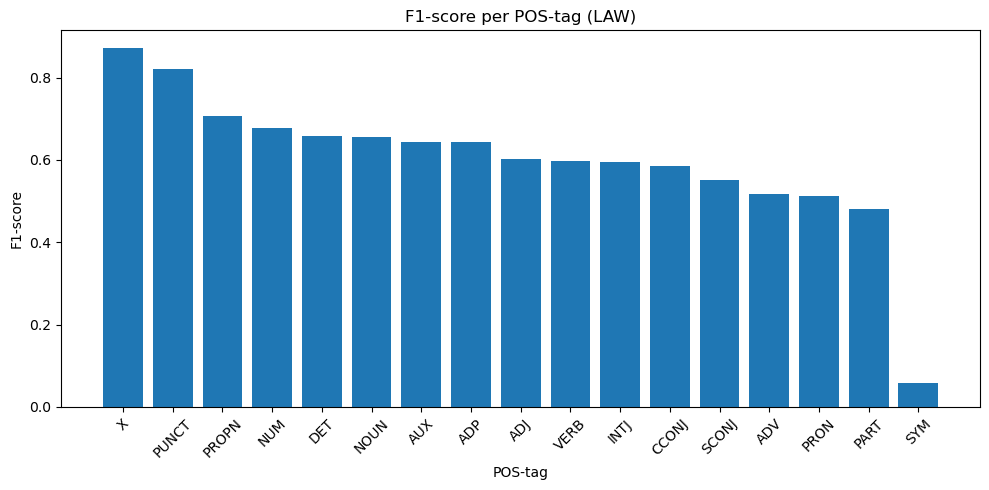

In [4]:
df_law = evaluate_pos(
    "/Users/sedatgunay/Desktop/MT-DATA/data/law/test.en.tag",
    "/Users/sedatgunay/Desktop/MT-DATA/outputs/eval_model_law_knn_4k_100T_8e-1l_beam5/hyp.eval_ready.tag",
    domain_name="LAW"
)

df_law
df_law.to_csv("results/pos_law_scores.csv", index=False)

In [5]:
!sacrebleu /Users/sedatgunay/Desktop/MT-DATA/data/law/test.en\
    -i /Users/sedatgunay/Desktop/MT-DATA/outputs/eval_model_law_knn_4k_100T_8e-1l_beam5/de-en.checkpoint_last.test.translation_knn.beam-5..hyp.eval_ready\
    -m bleu -b -w 2 --sentence-level \
    > results/bleu_scores_law.txt

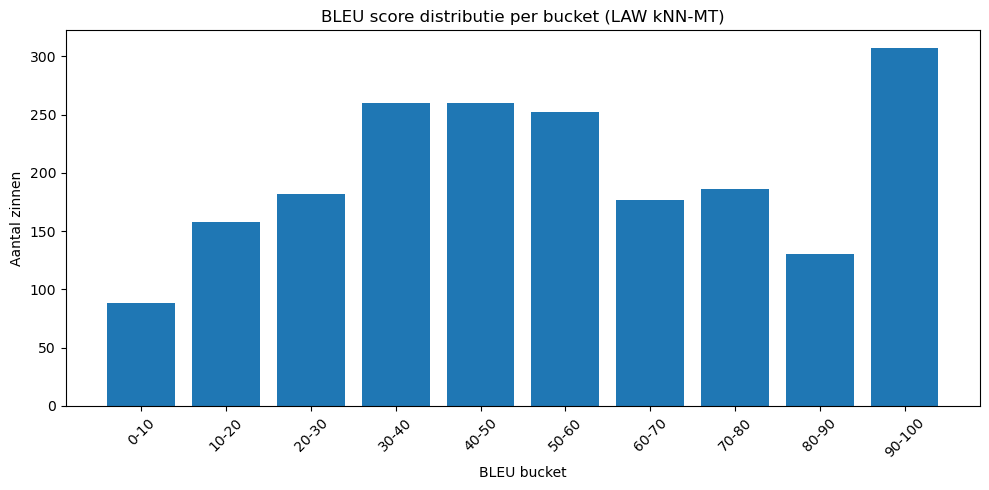

In [6]:
from analysis import analyze_bleu_buckets_single_system

bleu_law = analyze_bleu_buckets_single_system("results/bleu_scores_law.txt", system_name="LAW kNN-MT")

In [7]:
import pandas as pd

# Laad BLEU-scores
with open("results/bleu_scores_law.txt") as f:
    scores = [float(line.strip()) for line in f]

# Vind indices van de laagste 5% (BLEU-outliers)
n = int(len(scores) * 0.05)
low_idx = sorted(range(len(scores)), key=lambda i: scores[i])[:n]

In [8]:
with open("/Users/sedatgunay/Desktop/MT-DATA/outputs/eval_model_law_knn_4k_100T_8e-1l_beam5/de-en.checkpoint_last.test.translation_knn.beam-5..hyp.eval_ready") as f:
    hyps = [line.strip() for line in f]
with open("/Users/sedatgunay/Desktop/MT-DATA/data/law/test.en") as f:
    refs = [line.strip() for line in f]

for i in low_idx:
    print(f"[{i}]")
    print("REF:", refs[i])
    print("HYP:", hyps[i])
    print("BLEU:", scores[i])
    print()

[17]
REF: Europass-CV
HYP: Europass CV
BLEU: 0.0

[170]
REF: Compensation bodies
HYP: Value added tax
BLEU: 0.0

[235]
REF: Operative event
HYP: Law applicable
BLEU: 0.0

[266]
REF: ´iatriki tis ergasias'
HYP: '- munloof
BLEU: 0.0

[340]
REF: Breaks
HYP: Blocking
BLEU: 0.0

[365]
REF: GlaxoSmithKline
HYP: GlaxoSmith 4
BLEU: 0.0

[404]
REF: Refunds
HYP: Reimbursement
BLEU: 0.0

[979]
REF: THE LAW RELATING TO DESIGNS
HYP: MATERIAL DESIGN DESIGN
BLEU: 0.0

[1029]
REF: Criteria applicable to examination bodies
HYP: Requirements for the Examination Bodies
BLEU: 0.0

[1087]
REF: Melilla,
HYP: 5608 / 2003
BLEU: 0.0

[1149]
REF: Exploratory fishing
HYP: An exploratory fishery
BLEU: 0.0

[1536]
REF: UAUkraine
HYP: Medicina
BLEU: 0.0

[1576]
REF: 9
HYP: 7
BLEU: 0.0

[1993]
REF: DECISIONS WHICH ARE WITHIN THE COMPETENCE OF THE DIRECTOR-GENERAL AND RELATE TO MATTERS SPECIFIED IN THIS ARTICLE SHALL NOT BE TAKEN UNTIL FIFTEEN DAYS HAVE ELAPSED SINCE THE OPINION OF THE ADVISORY COMMITTEE WAS GIVEN , 

In [9]:
import pandas as pd

# Laad scores
with open("results/bleu_scores_law.txt") as f:
    scores = [float(line.strip()) for line in f]

# Laad POS-tags
with open("/Users/sedatgunay/Desktop/MT-DATA/outputs/eval_model_law_knn_4k_100T_8e-1l_beam5/hyp.eval_ready.tag") as f:
    tags = [line.strip().split() for line in f]

# Selecteer laagste 5% indexen
n = int(len(scores) * 0.05)
outlier_idx = sorted(range(len(scores)), key=lambda i: scores[i])[:n]

# Verzamel POS-tags van outliers
outlier_tags = [tags[i] for i in outlier_idx]
flat_tags = [tag for line in outlier_tags for tag in line]

# tags = lijst met lijstjes van POS per zin (al geladen bij stap 1)
all_flat_tags = [tag for line in tags for tag in line]

In [11]:
from collections import Counter

tag_counts = Counter(flat_tags)
df_pos_outliers = pd.DataFrame(tag_counts.items(), columns=["POS", "Count"])
df_pos_outliers = df_pos_outliers.sort_values(by="Count", ascending=False)
print(df_pos_outliers)

      POS  Count
1    NOUN    425
5     ADP    290
6     DET    224
2    VERB    153
0   PROPN    137
3     ADJ    113
9     AUX    112
13  CCONJ     53
11    ADV     41
8    PRON     39
4     NUM     38
14  PUNCT     31
10   PART     25
12  SCONJ     20
15      X     17
7     SYM      7
16   INTJ      4


In [12]:
total_counts = Counter(all_flat_tags)
df_total = pd.DataFrame(total_counts.items(), columns=["POS", "Total"])

In [13]:
df_outlier = pd.DataFrame(Counter(flat_tags).items(), columns=["POS", "Outlier"])
df_merged = df_outlier.merge(df_total, on="POS")

# Voeg percentage kolom toe
df_merged["Outlier %"] = 100 * df_merged["Outlier"] / df_merged["Total"]

# Sorteer op relatieve oververtegenwoordiging
df_merged = df_merged.sort_values(by="Outlier %", ascending=False)

df_merged

,POS,Outlier,Total,Outlier %
11,ADV,41,713,5.750351
9,AUX,112,2713,4.128271
1,NOUN,425,12183,3.488468
8,PRON,39,1121,3.479037
6,DET,224,6894,3.249202
3,ADJ,113,3483,3.244330
2,VERB,153,4958,3.085922
5,ADP,290,9491,3.055526
10,PART,25,820,3.048780
14,PUNCT,31,1043,2.972196
